## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution
3. Surface plots

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
data_dir = "/home/nikhil/projects/Parkinsons/qpn/"

session = "ses-01"
FS_dir = f"{data_dir}/derivatives/freesurfer/v6.0.1/"
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"
FS_DKT_dir = f"{FS_dir}/freesurfer-agg/{session}/"

DKT_csv = f"{FS_DKT_dir}/DKTatlas_average_thickness.csv"

ASEG_csv = f"{FS_DKT_dir}/aseg_subcortical_volumes.csv"

tabular_dir = f"{data_dir}/tabular/"

current_release = "release_Nov2022"

figs_dir = "../figs/"

# Current mr_proc manifest
current_mr_proc_manifest_csv = f"{tabular_dir}{current_release}/mr_proc_manifest.csv"

# UKB and FS fields map
ukbb_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"
# DKT fields and labels
ukbb_dkt_ct_fields = f"{ukbb_dir}/region_field_ids/UKBB_DKT_CT_Fields.csv"
# ASEG fields and labels
ukbb_aseg_vol_fields = f"{ukbb_dir}/region_field_ids/UKBB_ASEG_vol_Fields.csv"


### Colormaps

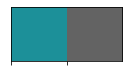

In [3]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#636363"
    PD = "#1c9099"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### Demographic data

In [26]:
demo_cols = ["bids_id","sex","dob","group","visit_01"]

demographics_df = pd.read_csv(current_mr_proc_manifest_csv)[demo_cols]
demographics_df["age"] = (pd.to_datetime(df["visit_01"]) - pd.to_datetime(df["dob"]))/ np.timedelta64(1, 'Y')

print(f"n_demographics_subs: {len(demographics_df)}")
demographics_df.head()

n_demographics_subs: 208


,bids_id,sex,dob,group,visit_01,age
0,sub-MNI0056D864854,M,1942-05-21,PD,2021-08-18,79.245980
1,sub-MNI0058D197308,M,1964-03-14,PD,2021-08-18,57.430337
2,sub-MNI0068D842090,M,1952-08-05,PD,2021-08-27,69.060966
3,sub-MNI0079D760662,F,1971-11-25,PD,2021-12-22,50.076319
4,sub-MNI0103D369057,M,1939-08-17,PD,2021-08-11,81.986625


### UKB - DKT - ASEG fields and names

In [5]:
### DKT metadata
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "_" + DKT_fields_df["roi"]

DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

lh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["Field ID"].values.astype("str"))
rh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["Field ID"].values.astype("str"))
rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])

# hemi specific dict
lh_DKT_field_roi_dict = dict(zip(lh_DKT_fields,rois))
rh_DKT_field_roi_dict = dict(zip(rh_DKT_fields,rois))


### ASEG metadata
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

ASEG_fields_sorted = list(ASEG_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

lh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["Field ID"].values.astype("str"))
rh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Right-"]["Field ID"].values.astype("str"))
global_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["Field ID"].values.astype("str"))
hemi_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["roi"])
global_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["roi"])

# hemi specific dict
lh_ASEG_field_roi_dict = dict(zip(lh_ASEG_fields,hemi_rois))
rh_ASEG_field_roi_dict = dict(zip(rh_ASEG_fields,hemi_rois))
global_ASEG_field_roi_dict = dict(zip(global_ASEG_fields,global_rois))
ASEG_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_ROI
0,43,26523,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle
1,44,26524,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle
2,45,26525,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle
3,46,26564,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Left-Accumbens-area
4,47,26595,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Right-Accumbens-area


### Read DKT data

In [6]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df = CT_DKT_df.drop(columns=["Unnamed: 0"])
CT_DKT_df = CT_DKT_df.rename(columns={"subject_id":"bids_id"})

bids_ids = list(CT_DKT_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

CT_DKT_df = pd.merge(CT_DKT_df,demographics_df,on="bids_id",how="left")
CT_DKT_df.head()

CT_DKT_df.head()

n_bids: 196


,bids_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27291,27292,27293,27294,27295,27296,27297,sex,dob,group
0,sub-PD00668D788170,2.419,2.414,2.009,2.761,2.560,2.338,2.483,2.350,2.049,...,2.135,2.402,2.285,2.604,2.372,2.272,2.835,M,1941-12-14,PD
1,sub-MNI0056D864854,2.209,2.546,1.945,2.934,2.509,2.347,2.480,2.148,2.106,...,2.167,2.415,2.434,2.644,2.386,2.092,2.617,M,1942-05-21,PD
2,sub-PD01677D994657,2.741,2.577,1.888,2.819,2.552,2.468,2.683,2.173,2.225,...,2.336,2.575,2.247,2.895,2.770,2.654,3.138,F,1964-12-01,PD
3,sub-MNI0147D193242,2.736,2.149,2.011,3.295,2.705,2.265,2.955,2.229,2.230,...,2.129,2.357,1.929,2.594,2.236,2.129,2.675,M,1945-06-15,CTRL
4,sub-PD00032D891772,2.690,2.512,2.034,3.973,2.580,2.315,2.730,2.257,2.125,...,2.294,2.487,2.203,2.784,2.480,2.380,2.736,M,1950-10-25,PD


### Filter demographics based on available BIDS data

In [28]:
demographics_df = demographics_df[demographics_df["bids_id"].isin(bids_ids)]
demographics_df.groupby(["group"])["age"].std()

group
CTRL    11.403467
PD       9.203378
Name: age, dtype: float64

### Split DKT data into left and right hemisphere

In [8]:
lh_CT_DKT_df = CT_DKT_df[lh_DKT_fields + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[rh_DKT_fields + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_field_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_field_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,bids_id,sex,dob,group,hemi
0,2.419,2.414,2.009,2.761,2.560,2.338,2.483,2.767,2.350,2.049,...,2.427,2.270,2.568,2.344,2.131,sub-PD00668D788170,M,1941-12-14,PD,lh
1,2.209,2.546,1.945,2.934,2.509,2.347,2.480,2.609,2.148,2.106,...,2.503,2.478,2.518,2.283,2.200,sub-MNI0056D864854,M,1942-05-21,PD,lh
2,2.741,2.577,1.888,2.819,2.552,2.468,2.683,3.007,2.173,2.225,...,2.644,2.271,2.744,2.537,2.441,sub-PD01677D994657,F,1964-12-01,PD,lh
3,2.736,2.149,2.011,3.295,2.705,2.265,2.955,3.026,2.229,2.230,...,2.388,1.919,2.567,2.155,2.483,sub-MNI0147D193242,M,1945-06-15,CTRL,lh
4,2.690,2.512,2.034,3.973,2.580,2.315,2.730,2.880,2.257,2.125,...,2.557,2.175,2.711,2.475,2.546,sub-PD00032D891772,M,1950-10-25,PD,lh


### Plot DKT

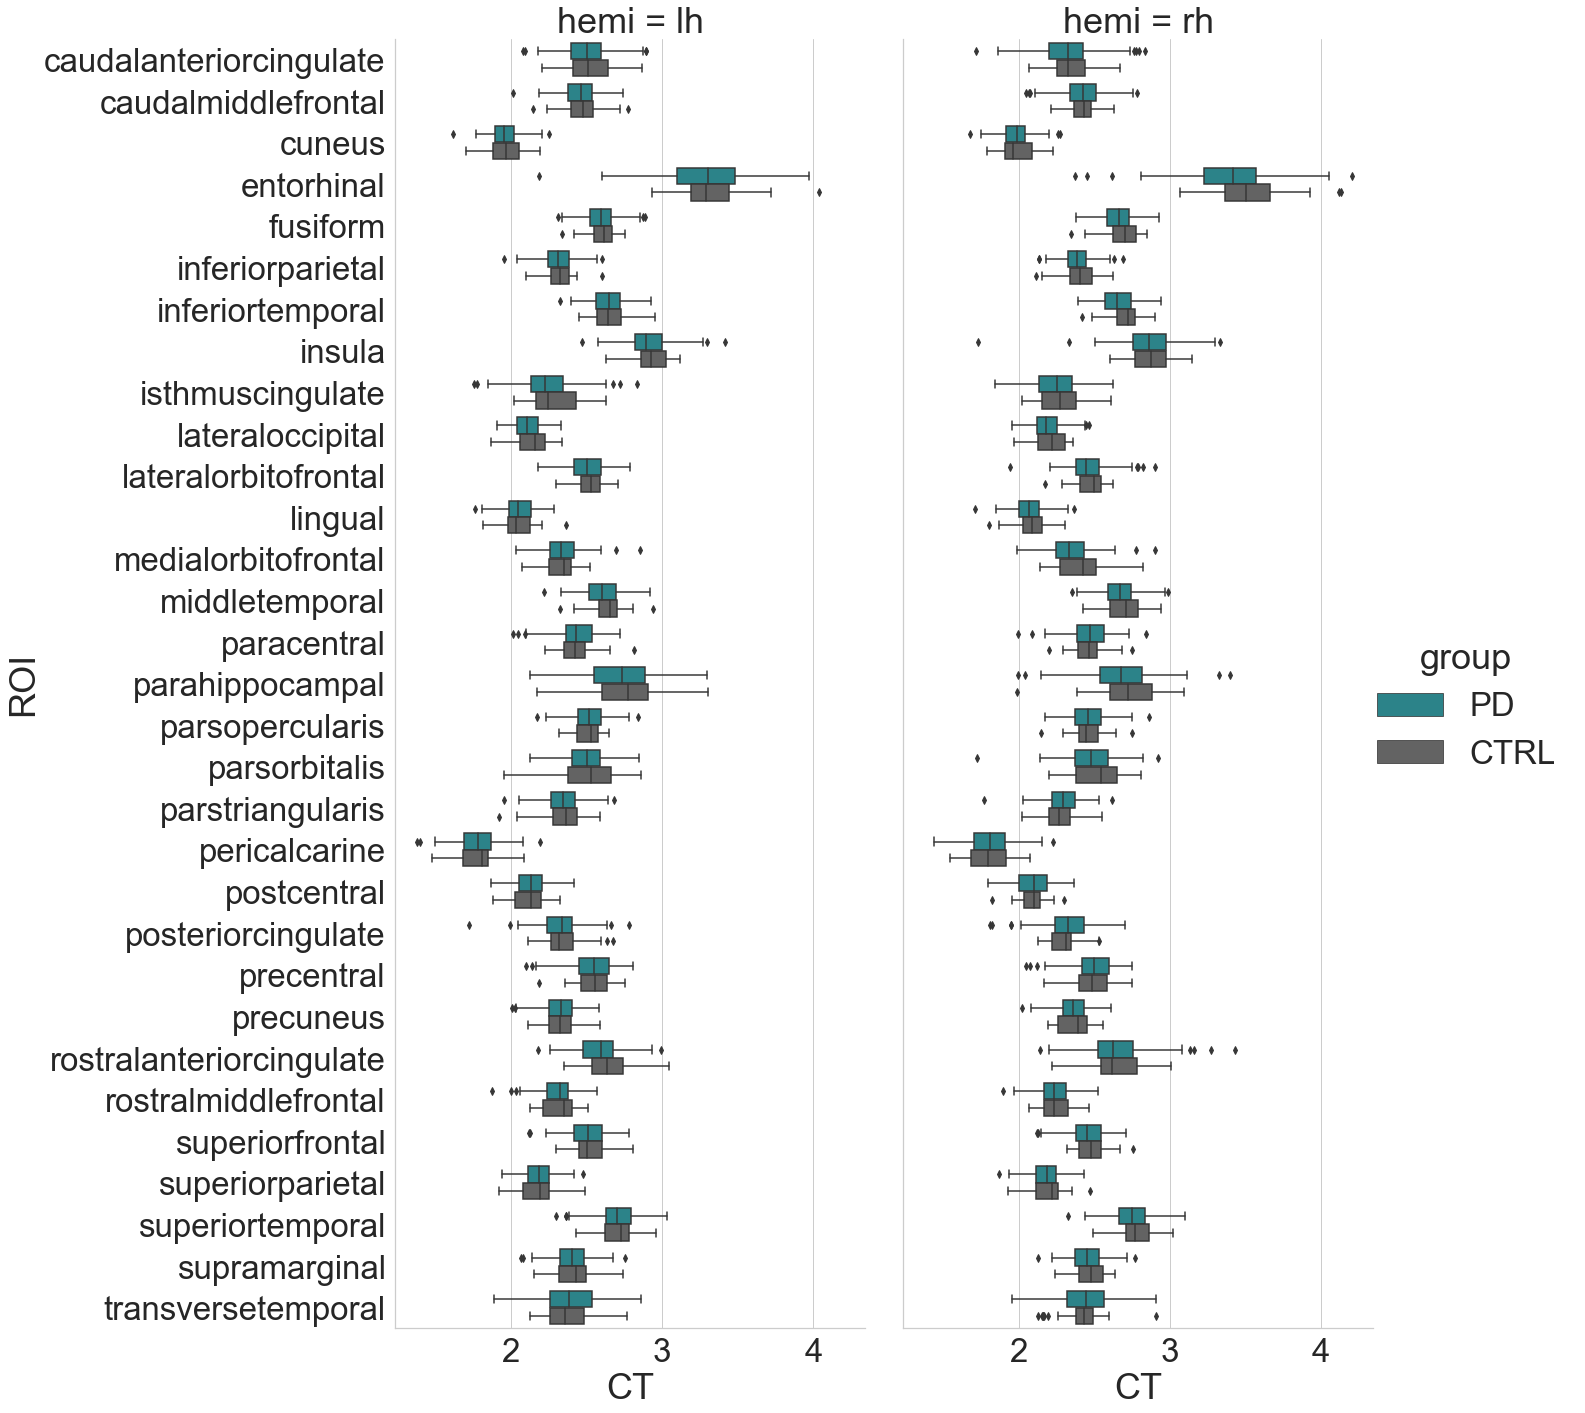

In [9]:
save_fig = True

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="group", col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Volumetric measures

In [10]:
vol_ASEG_df = pd.read_csv(ASEG_csv)
vol_ASEG_df = vol_ASEG_df.drop(columns=["Unnamed: 0"])
vol_ASEG_df = vol_ASEG_df.rename(columns={"subject_id":"bids_id"})

bids_ids = list(vol_ASEG_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

# Subset fields because UKB has more fields than freesurfer enlists
lh_ASEG_fields = list(set(lh_ASEG_fields) & set(vol_ASEG_df.columns))
rh_ASEG_fields = list(set(rh_ASEG_fields) & set(vol_ASEG_df.columns))
global_ASEG_fields = list(set(global_ASEG_fields) & set(vol_ASEG_df.columns))

# Merge with demographics info
vol_ASEG_df = pd.merge(vol_ASEG_df,demographics_df[demo_cols],on="bids_id",how="left")

vol_ASEG_df.head()

n_bids: 196


,bids_id,26523,26524,26525,26564,26595,26563,26594,26526,26514,...,26596,26528,26567,26598,26529,26566,26597,sex,dob,group
0,sub-PD00668D788170,2885.600098,1519.500000,0.0,380.600006,435.799988,1173.800049,1349.000000,22150.000000,1155866.0,...,4110.700195,4413.700195,841.200012,853.599976,0.000000,19.299999,79.500000,M,1941-12-14,PD
1,sub-MNI0056D864854,2971.100098,2498.600098,0.0,381.299988,388.799988,1364.099976,1682.099976,20670.599609,1246253.0,...,3528.100098,6660.799805,930.000000,1064.699951,0.000000,20.000000,63.700001,M,1942-05-21,PD
2,sub-PD01677D994657,903.200012,1242.500000,0.0,400.899994,541.099976,1275.900024,1401.500000,21717.900391,1143772.0,...,3677.300049,1031.300049,290.600006,368.000000,0.000000,29.100000,14.000000,F,1964-12-01,PD
3,sub-MNI0147D193242,1718.599976,1588.199951,0.0,468.600006,429.799988,1521.800049,1512.699951,20151.300781,941703.0,...,3290.399902,6444.000000,841.799988,1131.800049,48.700001,90.900002,21.700001,M,1945-06-15,CTRL
4,sub-PD00032D891772,1853.900024,2748.300049,0.0,588.200012,626.700012,1553.800049,1511.099976,22589.099609,1147237.0,...,4099.100098,1096.900024,865.299988,764.500000,0.000000,107.599998,19.700001,M,1950-10-25,PD


### Split DKT data into left and right hemisphere

In [11]:
lh_vol_ASEG_df = vol_ASEG_df[lh_ASEG_fields + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[rh_ASEG_fields + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_ASEG_fields + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_ASEG_field_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_ASEG_field_roi_dict)
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_field_roi_dict)

vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

vol_ASEG_df.head()

,Lateral-Ventricle,Caudate,Inf-Lat-Vent,Cerebellum-Cortex,vessel,Cerebellum-White-Matter,Pallidum,VentralDC,choroid-plexus,Accumbens-area,Thalamus-Proper,Amygdala,Putamen,Hippocampus,bids_id,sex,dob,group,hemi
0,12196.299805,3048.800049,566.299988,50515.601562,19.299999,14220.799805,1984.000000,4244.200195,841.200012,380.600006,7281.100098,1173.800049,4601.399902,3667.899902,sub-PD00668D788170,M,1941-12-14,PD,lh
1,30950.300781,3506.000000,1578.400024,49035.000000,20.000000,13299.500000,1685.800049,3832.800049,930.000000,381.299988,6604.500000,1364.099976,4640.000000,3633.199951,sub-MNI0056D864854,M,1942-05-21,PD,lh
2,5203.799805,2716.600098,698.700012,48556.000000,29.100000,14780.099609,1727.099976,3584.199951,290.600006,400.899994,6945.299805,1275.900024,4496.399902,3112.899902,sub-PD01677D994657,F,1964-12-01,PD,lh
3,11070.700195,3327.899902,614.799988,50057.199219,90.900002,13551.700195,1741.900024,3704.699951,841.799988,468.600006,6637.500000,1521.800049,4531.399902,3689.600098,sub-MNI0147D193242,M,1945-06-15,CTRL,lh
4,17603.199219,2741.300049,707.099976,49177.101562,107.599998,12986.599609,2033.300049,4125.299805,865.299988,588.200012,6905.200195,1553.800049,4820.299805,3872.199951,sub-PD00032D891772,M,1950-10-25,PD,lh


### Plot ASEG
- hemi 
- global

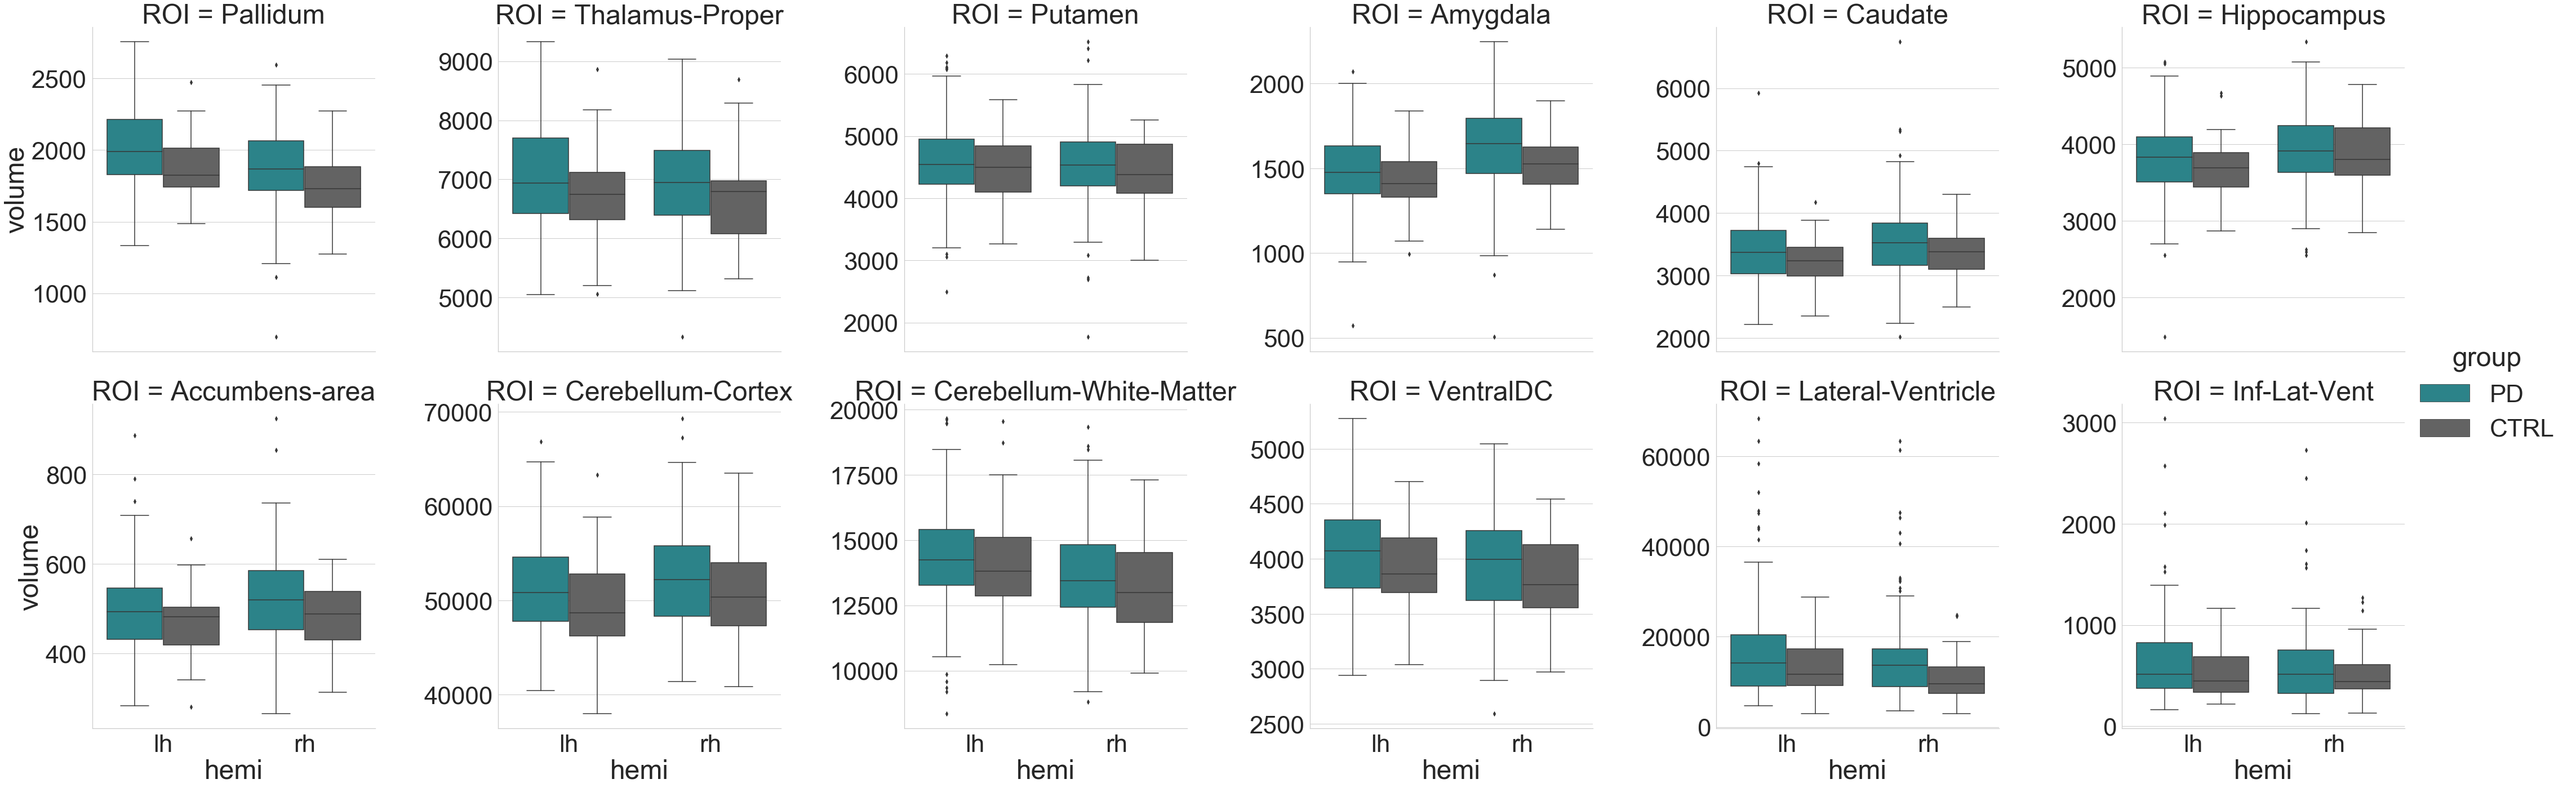

In [12]:
save_fig = True

vol_ASEG_df_melt = vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

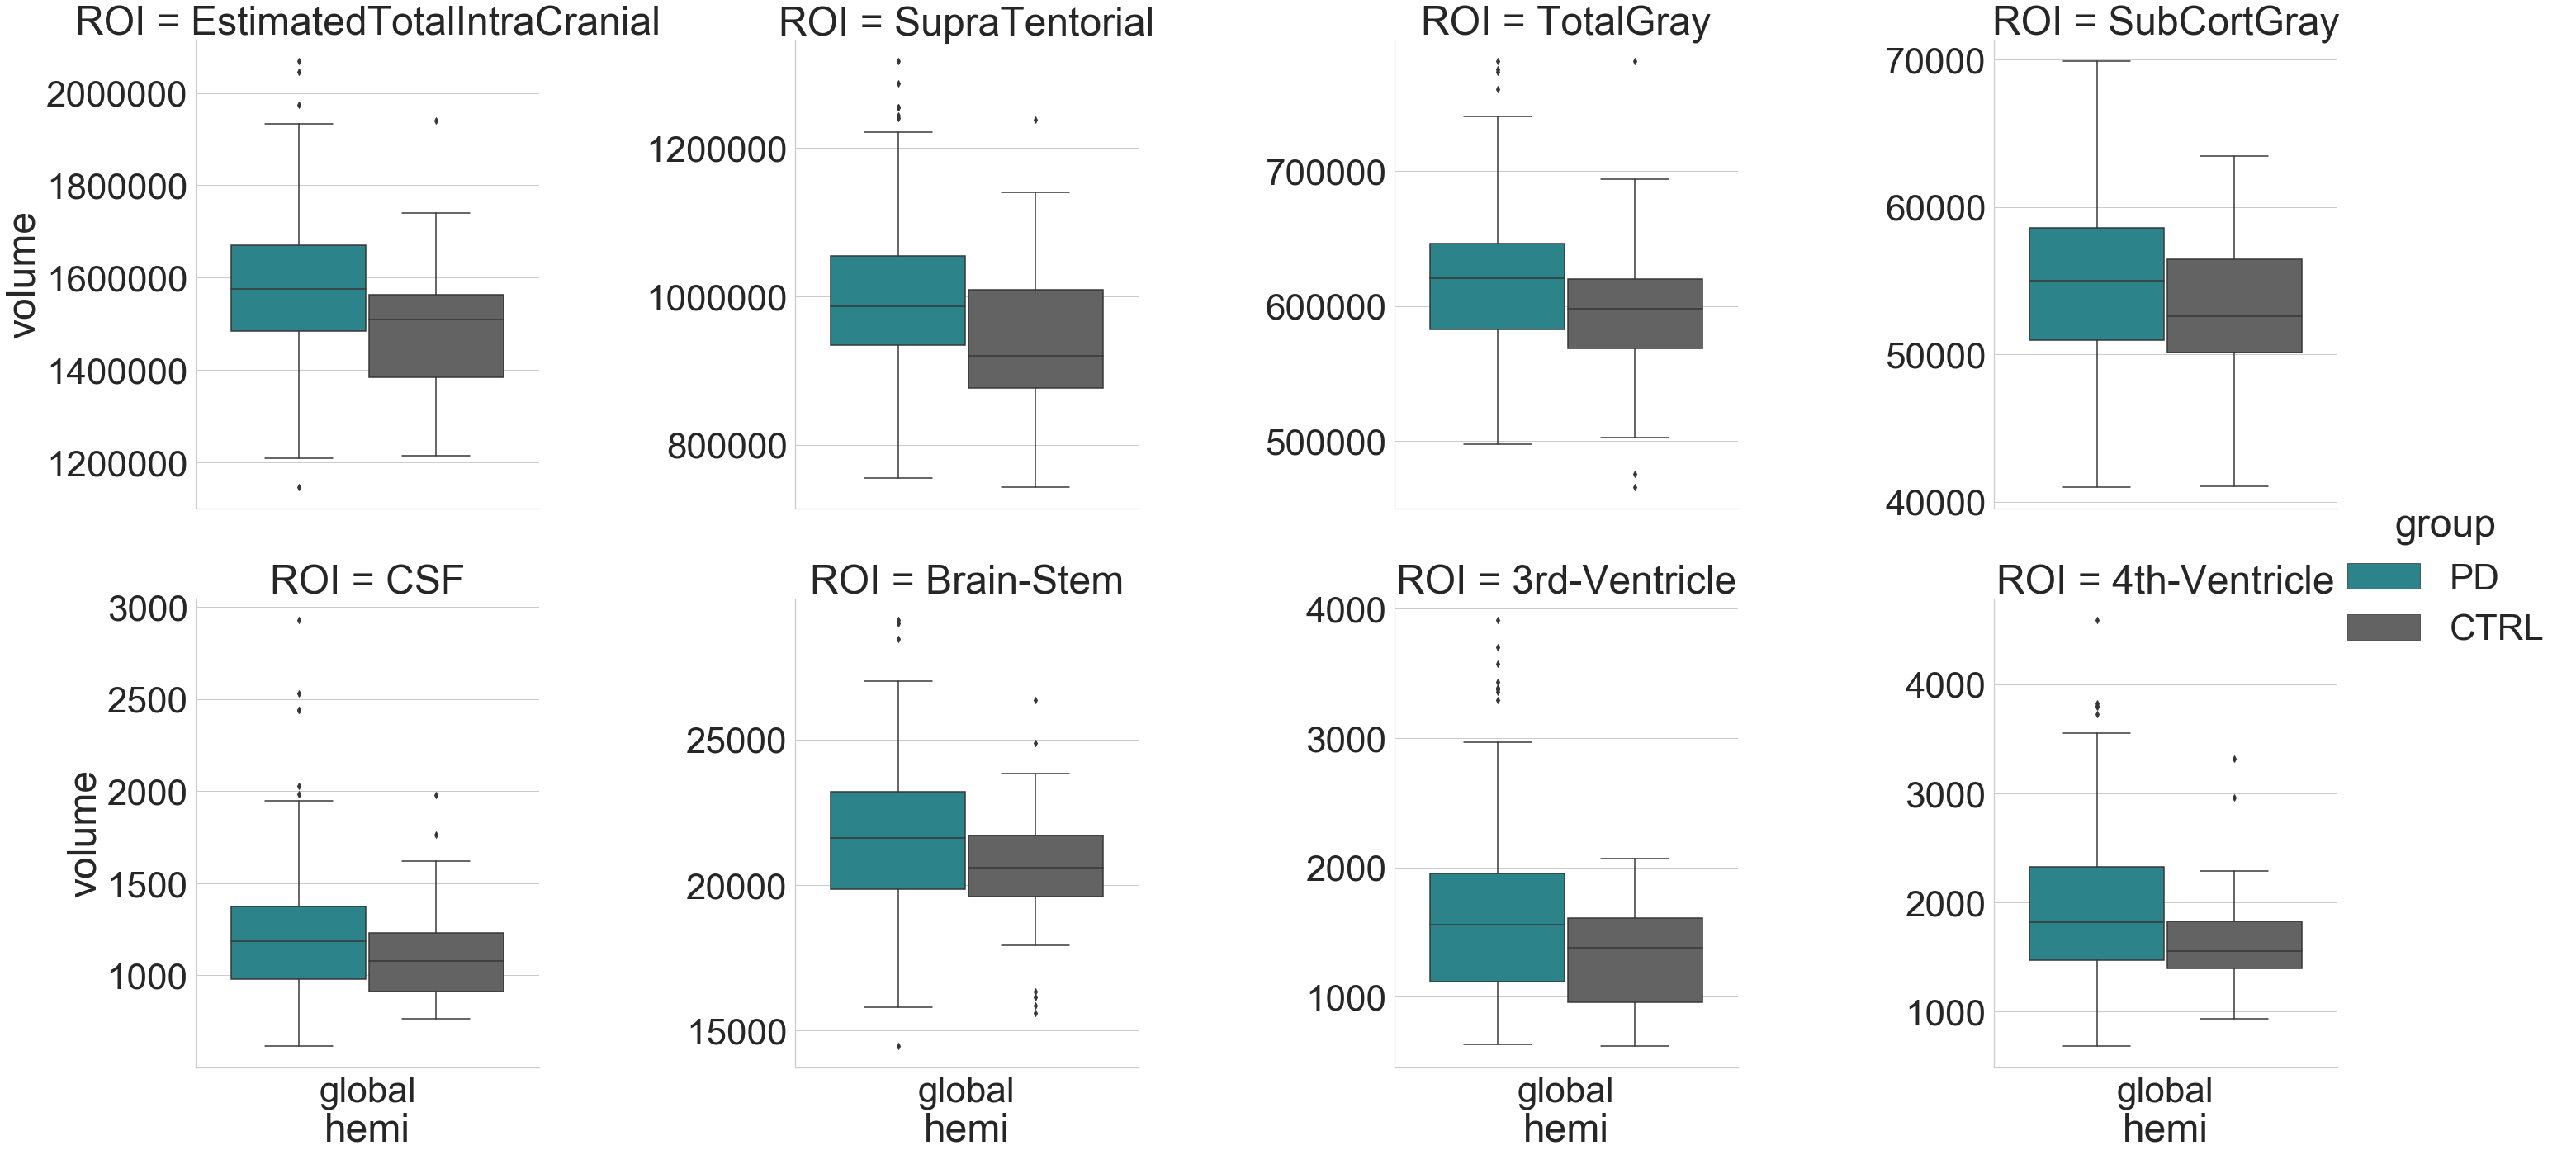

In [13]:
save_fig = True

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["EstimatedTotalIntraCranial", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

In [17]:
g.savefig(f"{figs_dir}/ASEG_global.png")

### Surface maps

In [14]:
fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
cmap = "Spectral" #"cubehelix"
view = 'lateral'
sns.set(font_scale=2)

In [15]:
fwhm_list = [5] #[0,5,10]
DX_groups = ["CTRL"] #,"PD"] 
hemi_list = ["lh"] #, "rh"]

for fwhm in fwhm_list:
    for i, group in enumerate(DX_groups):
        for j, hemi in enumerate(hemi_list):
            CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{group}_{fwhm}mm.mgh")
            avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))

            stat_map = avg_CT

            if hemi == "lh":
                hemisphere = "left"
            else:
                hemisphere = "right"

            bg_map=fsaverage[f"sulc_{hemisphere}"]
            fs_surf = fsaverage[f'pial_{hemisphere}']
            
            fig = plt.figure(figsize=(10, 6))
            fig_file = f"{figs_dir}/surf/{hemi}_surf_CT_{group}_{fwhm}mm.png"
            
            with sns.axes_style("white"):
                plotting.plot_surf_stat_map(
                    fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
                    colorbar=True, threshold=1, vmax=4.3, output_file=fig_file, cmap=cmap, figure=fig
            )

#bg_map=bg_map,vmax=4.5,

### CTRL - PD

In [16]:
fwhm = 5
cmap = "Spectral"
hemi_list = ["lh", "rh"]

for j, hemi in enumerate(hemi_list):
    CT_img_CTRL = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_CTRL_{fwhm}mm.mgh")
    avg_CT_CTRL = np.squeeze(np.mean(CT_img_CTRL.get_fdata(),axis=3))

    CT_img_PD = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_PD_{fwhm}mm.mgh")
    avg_CT_PD = np.squeeze(np.mean(CT_img_PD.get_fdata(),axis=3))

    stat_map = avg_CT_CTRL - avg_CT_PD

    if hemi == "lh":
        hemisphere = "left"
    else:
        hemisphere = "right"

    bg_map=fsaverage[f"sulc_{hemisphere}"]
    fs_surf = fsaverage[f'pial_{hemisphere}']
    
    fig = plt.figure(figsize=(10, 6))
    fig_file = f"{figs_dir}/surf/{hemi}_surf_CT_diff_{fwhm}mm.png"
    
    with sns.axes_style("white"):
        plotting.plot_surf_stat_map(
            fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
            colorbar=True, threshold=0.15, output_file=fig_file, cmap=cmap, figure=fig
        )